In [1]:
from numpy import *
from IPython.display import display, Math, Latex

import numpy as np
from scipy import linalg
from scipy.linalg import inv
from scipy.linalg import expm
from matplotlib.pyplot import *
from scipy import integrate
from scipy.integrate import solve_ivp

# Task 1.1
In this task we our RK4step method with the simplest case for $f(t,y) = \lambda y$. With $\lambda = -1,-2,-3$.
RK4step is defined according to the theory in the project instructions.

In [2]:
def RK4step(f,told,uold,h):

    Y1= f(told,uold)
    Y2 = f(told + 0.5*h,uold + h*0.5*Y1)
    Y3 = f(told + 0.5*h,uold + h*0.5*Y2)
    Y4 = f(told + h,uold + h*Y3)
    
    unew= uold + h*(Y1 + 2*Y2 + 2*Y3 + Y4)/6
    
    return unew

def RK4Int(f,y0,t0,tf,N): #Function that integrates an interval with N steps.
    uold = y0 #Initial value.
    told=t0 #starting value for t.
    h=(tf-t0)/N #equal stepsize depending on number of steps.
    approx=[]
    while told<tf: #integrates the interval t0 to tf.
        approx.append(uold) #first time through the loop saves value of y0
        utemp=RK4step(f,told,uold,h) #takes one step at t0,y0
        told=told+h #updates the time point one step h.
        uold=utemp #updates uold to new value after one step
    approx.append(uold) # Saves the last step taken.
    return approx

def RK_errVSh(A,f,y0,t0,tf): #Plots the error between approximation and real solution of y' = lambda * y
    error=[]
    h=[]
    
    truesol = expm(A*tf)@y0 #Solution for y'=lambda * y with initial value y0.
    for i in range(10):
        N= 2**(i+5)
        approx=RK4Int(f,y0,t0,tf,N)
        err = linalg.norm(approx[-1]-truesol)
        error.append(err)
        h.append((tf-t0)/N)   
    loglog(h,error)
    grid(True,'both')

Here we plot the results of our test with $\lambda = -1,-2,-3$.
Which produces graphs with a slope of 4 when plotted in loglog.

Text(0, 0.5, 'Error')

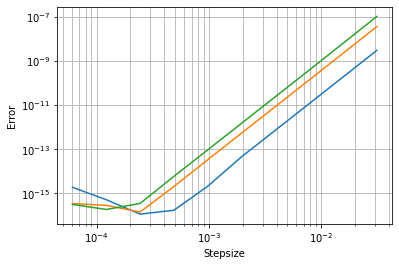

In [3]:
def f1(t,y):
    return -y
def f2(t,y):
    return -2*y
def f3(t,y):
    return -3*y

RK_errVSh(np.array([[-1]]),f1,array([1]),0,1)
RK_errVSh(np.array([[-2]]),f2,array([1]),0,1)
RK_errVSh(np.array([[-3]]),f3,array([1]),0,1)
xlabel("Stepsize")
ylabel("Error")

#### Also works with matrix input.

For example A = $$\begin{bmatrix}-1 & 100 \\0 & -30\end{bmatrix}$$



Text(0, 0.5, 'Error')

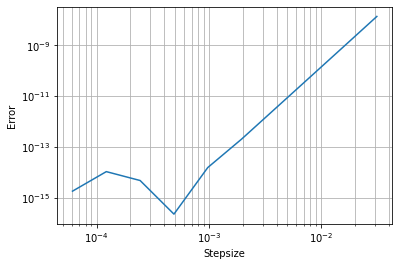

In [4]:
def fM(t,y):
    Atest=np.array([[-1,100],[0,-30]])
    return Atest@y
RK_errVSh(np.array([[-1,100],[0,-30]]),fM,array([1,1]),0,1)
xlabel("Stepsize")
ylabel("Error")

# Task 1.2



In [5]:
def RK34step(f,told,uold,h):
        
    Y1= f(told,uold)
    Y2 = f(told+0.5*h,uold+h*Y1*0.5)
    Y3 = f(told+0.5*h,uold+h*Y2*0.5)
    Y4 = f(told+h,uold+h*Y3)
    
    Z3 = f(told+h,uold-h*Y1+2*h*Y2)
        
    unew= uold + h*(Y1+2*Y2+2*Y3+Y4)/6
    
    err = linalg.norm(h*(2*Y2+Z3-2*Y3-Y4)/6) #l_n+1
    return unew,err

# Task 1.3
When defining the new stepsize we use the given PI controller which is defined as follows:


$$ \begin{equation}
h_{n} =   \bigg( \frac{TOL}{r_{n}} \bigg) ^{2/(3k)} \bigg( \frac{TOL}{r_{n-1}} \bigg) ^{-1/(3k)} \cdot h_{n-1}.
\end{equation}
$$

This controls the stepsize to be around the tolerance, using the current error and old error as input and with $k$ given as $k=4$.

In [6]:
def newstep(tol,err,errold,hold,k):
    hnew=(tol/err)**(2/(3*k)) * (tol/errold)**(-1/(3*k)) * hold
    return hnew

# Task 1.4
#### Combining RK34 and newstep. 

In [7]:
def adaptiveRK34(f,t0,tf,y0,tol=1e-6):
    k=4 
    hold=(abs(tf-t0)*tol**(1/4))/(100*(1+linalg.norm(f(t0,y0)))) #Initial stepsize from instructions
    h=hold 
    told=t0
    uold=y0
    errold=tol #sets the previous error to be equal to TOL initially.
    t=[]
    y=[]
    N=0 #Step counter
    while (told+h)<tf: #Loops until told is less than one step away from tf.
        unew,err=RK34step(f,told,uold,h) 
        uold = unew #Updates y after one step
        t.append(told) #saving t
        y.append(uold) #saving y
        told=told+h # t value is moved one step
        h=newstep(tol,err,errold,h,k) #new stepsize is calculated from the current error and old error
        errold=err #errold is set to previous error and err gets the current value from RK34step in next loop.
        N+=1
    hlast=tf-told # One last step so we land exactly at tf
    ulast,err=RK34step(f,told,uold,hlast) #last y value
    y.append(ulast)
    t.append(tf)
    N+=1
    return np.array(t),np.stack(y), N # np.stack stacks the return value of y into a single single array instead of a array of arrays

# Task 2.1
In this task we try our adaptive method on the $\textbf{Lotka-Volterra equation}$, which models a predator prey system. This described by the following system of diffrential equations:
$$
\begin{equation}
\dot x = ax - bxy \\
\dot y = cxy - dy.
\end{equation}
$$
Where x is the number of rabbits and y is the number of foxes.

In [33]:
def LotkaVolterra(t,y):
    (a,b,c,d)=[3,9,15,15] #Parameters given
    dydt = [a*y[0] - b*y[0]*y[1], c*y[0]*y[1]-d*y[1]]
    return np.array(dydt)

Here we plot with initial condition $y_{0} = [1,1]$, $t_{0} = 0$ and $t_{f} = 11$ We can see that the solution forms a closed loop.

Text(0, 0.5, 'y, foxes')

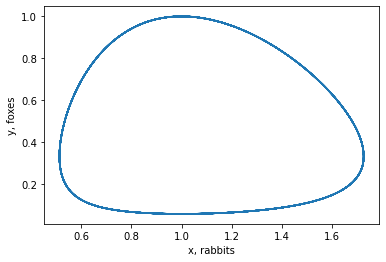

In [9]:
f = lambda t,y: LotkaVolterra(t,y)

y0=[1,1]
t0=0
tf=11

t, y, n = adaptiveRK34(f,t0,tf,y0) 
figure()
plot(y[:,0],y[:,1]) #Plots x against y
#plot(y[:,0],y[:,1],'.')
xlabel("x, rabbits")
ylabel("y, foxes")

#### Plotting x and y against t. 
Carefully observing the figures we can read the period to be around ≈ 1.05

Text(0, 0.5, 'y')

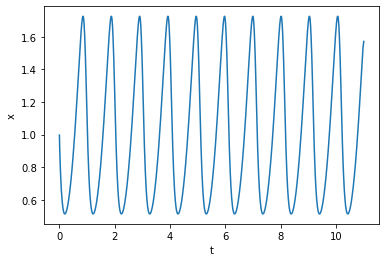

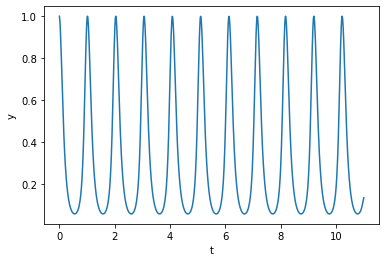

In [10]:
plot(t,y[:,0])

xlabel("t")
ylabel("x")

figure()
plot(t,y[:,1])
xlabel("t")
ylabel("y")

#### Testing different initital conditions
Period seems to be fairly dependent on initial conditiions.

Text(0, 0.5, 'x')

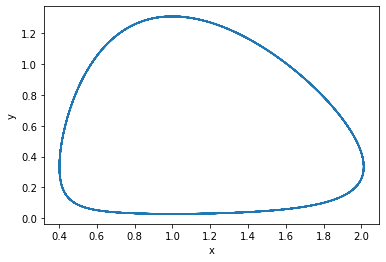

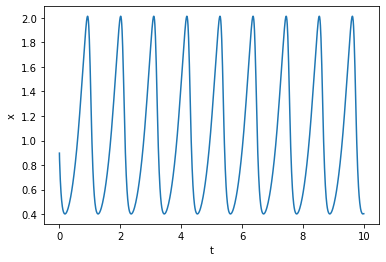

In [27]:
tf=10
y0=[0.9,1.3]

t, y, n = adaptiveRK34(f,t0,tf,y0)
plot(y[:,0],y[:,1],)
xlabel("x")
ylabel("y")

figure()
plot(t,y[:,0])
xlabel("t")
ylabel("x")

Text(0, 0.5, 'y')

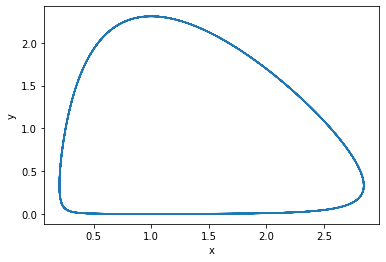

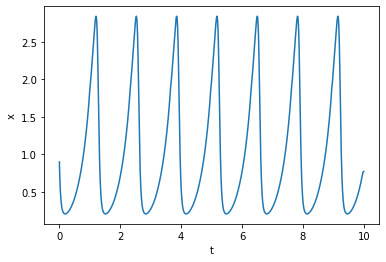

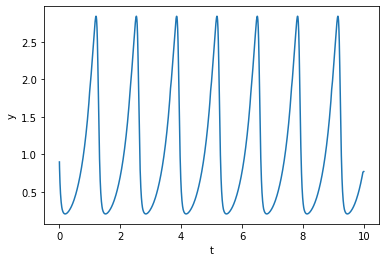

In [28]:
y0=[0.9,2.3]
#y0=[1,4.3]

t, y, n = adaptiveRK34(f,t0,tf,y0)
plot(y[:,0],y[:,1],)
xlabel("x")
ylabel("y")

figure()
plot(t,y[:,0])
xlabel("t")
ylabel("x")
figure()
plot(t,y[:,0])
xlabel("t")
ylabel("y")

Text(0, 0.5, 'x')

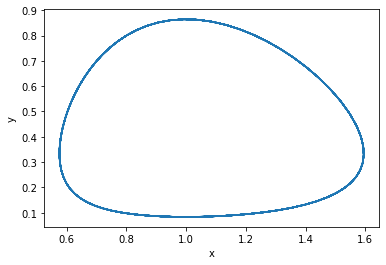

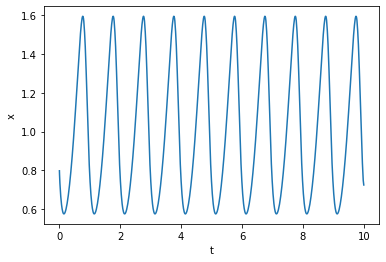

In [29]:
y0=[0.8,0.8]
t, y, n = adaptiveRK34(f,t0,tf,y0)

plot(y[:,0],y[:,1],)
xlabel("x")
ylabel("y")
figure()
plot(t,y[:,0])
xlabel("t")
ylabel("x")

Text(0, 0.5, 'H(x,y)')

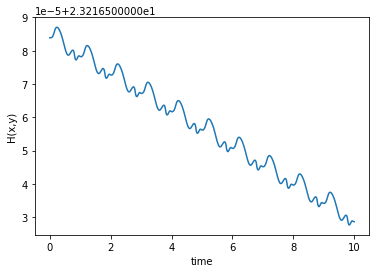

In [30]:
def H(x,y):
    (a,b,c,d)=[3,9,15,15]
    return c*x+b*y-d*log(x)-a*log(y)

plot(t,H(y[:,0],y[:,1])) #Plots H against time
xlabel("time")
ylabel("H(x,y)")

Text(0, 0.5, '$|H(x,y)/H(x(0),y(0))-1|$')

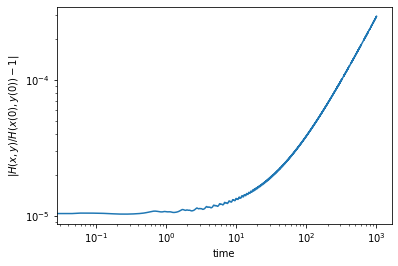

In [25]:
y0=[1,1]
t0=0
tf=1000
t, y, n = adaptiveRK34(f,t0,tf,y0)

Hinv = abs(H(y[:,0],y[:,1])/H(y0[0],y0[1])-1)
loglog(t,Hinv)
xlabel("time")
ylabel(r'$|H(x,y)/H(x(0),y(0))-1|$')

# Task 3.1
In this task we challenge our model with solving stiff problems.
One such problem is the $\textbf{van der Pol equation}$ which describes an electric oscillator circuit and is given by:
$$
\begin{align*}
y'_{1} &= y_{2} \\
y'_{2} &= \mu \cdot (1-y_{1}^{2}) \cdot y_{2}-y_{1}.
\end{align*}
$$

In [31]:
def vanderPol(t,y,my):
    y1=y[0]
    y2=y[1]
    dydt=[y2, (my*(1-(y1**2))*y2)-y1]
    return np.array(dydt)

In the first figure we plot $y_{2}$ against $y_{1}$.

In the second we plot $y_{2}$ against $t$.

Text(0, 0.5, '$y_{2}$')

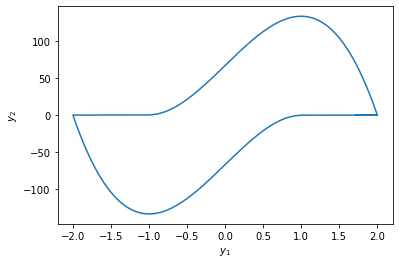

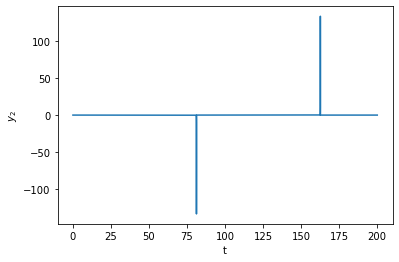

In [57]:
my=100
y0=[2,0]
t0=0
N=[]
tf=2*my
f = lambda t,y: vanderPol(t,y,my=my) 
t, y, n = adaptiveRK34(f,t0,tf,y0,1e-8)
plot(y[:,0],y[:,1])
xlabel(r'$y_{1}$')
ylabel(r'$y_{2}$')
figure()
plot(t,y[:,1])
xlabel('t')
ylabel(r'$y_{2}$')

#### Testing different initital values 
Here the period appears to be independent of initial values, the plot is only shifted to the left or right.

Text(0, 0.5, '$y_{2}$')

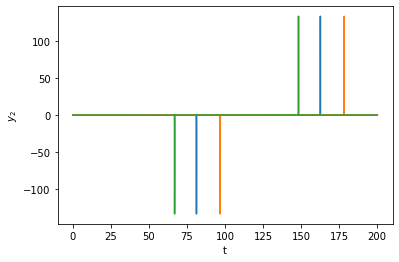

In [59]:
my=100
f = lambda t,y: vanderPol(t,y,my=my) 
tf=2*my

y0=[2,0]
t, y, n = adaptiveRK34(f,t0,tf,y0,1e-8)
plot(t,y[:,1])

y0=[2.1,0]
t, y, n = adaptiveRK34(f,t0,tf,y0,1e-8)
plot(t,y[:,1])

y0=[1.9,0]
t, y, n = adaptiveRK34(f,t0,tf,y0,1e-8)
plot(t,y[:,1])
xlabel('t')
ylabel(r'$y_{2}$')

# Task 3.2

With this task we push our method to the limit on how stiff problems it can handle, plotting the number of steps it requires for a given value of $\mu$.

10
15
22
33
47
68
100
150
220
330
470
680
1000


Text(0, 0.5, 'N')

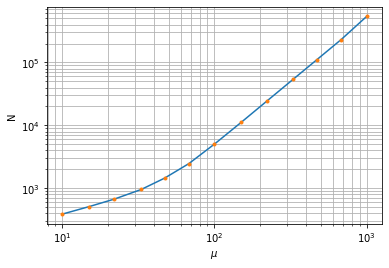

In [44]:
E6 = np.array([10,15,22,33,47,68,100,150,220,330,470,680,1000])
y0=[2,0]
t0=0
N=[]

for i in E6:
    my = i
    tf=0.7*my
    print(i)
    f = lambda t,y: vanderPol(t,y,my=my)
    t, y, n = adaptiveRK34(f,t0,tf,y0,1e-8)
    N.append(n)
    

loglog(E6,N)
loglog(E6,N,'.')
grid(True,'both')
xlabel(r'$\mu$')
ylabel('N')

Does $N \sim C \cdot \mu^{q}$? It appears that for the first few points it follows a linear trend and for the rest also but with a slighty steeper slope. Using np.polyfit to obtain a linear approximation we get that $q ≈ 0.94$ for the first part and $q≈1.99$ for the second part.

$ln(N) = q \cdot ln(\mu) + D, $ where $D = ln(C)$.
Stiffness increases with $\mu$. 

Our model can just barely handle $\mu = 1000$.

In [52]:
pfit1 = np.polyfit(log(E6[:6]),log(N[:6]),1)
pfit2 = np.polyfit(log(E6)[5:],log(N[5:]),1)
print(f'Slope of first part = {pfit1[0]}')
print(f'Slope of second part = {pfit2[0]}')

Slope of first part = 0.9453090529371451
Slope of second part = 1.9990712778560449


#### Comparing with built in solver
Now we compare with the built in solver scipy.integrate.solve_IVP. It computes the result almost instantly showing basically no correlation between number of steps and value of $\mu$. Only requiring about 35 steps for $\mu = 10000$.

Text(0, 0.5, 'N')

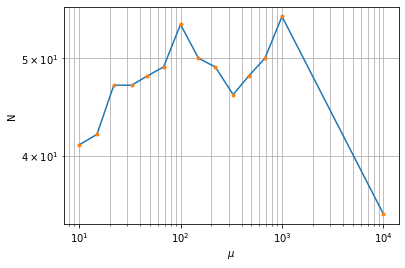

In [61]:
E6 = np.array([10,15,22,33,47,68,100,150,220,330,470,680,1000,10000])
y0=[2,0]
t0=0
N_steps=[]
for i in E6:
    my = i
    tf=0.7*my
    tspan=np.array([t0,tf])
    f = lambda t,y: vanderPol(t,y,my=my)
    OUT = solve_ivp(f,tspan,y0,method='BDF')
    N_steps.append(len(OUT.t))

loglog(E6,N_steps)
loglog(E6,N_steps,'.')
grid(True,'both')
xlabel(r'$\mu$')
ylabel('N')

712

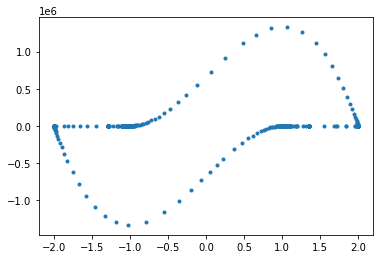

In [68]:
my=1000000
tf=2*my
tspan=[t0,tf]
f = lambda t,y: vanderPol(t,y,my=my)
OUT = solve_ivp(f,tspan,y0,method='BDF')
plot(OUT.y[0,:],OUT.y[1,:],'.')
len(OUT.t)

In [149]:
%matplotlib qt